# Preparing and converting data

In [11]:
##tentative implémentation code Thibault

In [248]:
from collections import defaultdict
from collections import namedtuple
from collections import Counter
from tqdm import tqdm

from thibaultScript import (
    import_known_tokens,
    compile_scores#,
#    convert_raw#,
#    vjui
)

from pandas import DataFrame, Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from numpy import mean, median

In [118]:
def convert_raw(gold, task_list=[], 
                form_fn=lambda x: x, 
                lemma_fn=lambda x: x, 
                pos_fn=lambda x: x,
                pos_key = "POS",
                remove_disambiguation = False
               ):
    """ Converts input data into Gold data.
        The main goal here is to treat cases like apostrophes, so that two tokens _l/'_
        became one _l'_
        And handle fucking roman numerals
    """
    temp_out = []
    pass_next = False
    
    for sentence in tqdm(gold):
        temp_sentence = []
        no_sentence_append = False
        # Handle roman numerals
        for idx,token in enumerate(sentence):
            if pass_next:
                pass_next = False
                continue
            
            new_token = {task: "_" for task in task_list}
            new_token.update({
                "form": form_fn(token["form"]),
                "lemma": lemma_fn(token["lemma"]),
                "POS": pos_fn(token[pos_key]),
            })
            # No disambiguation at the lemmatizer lever
            if remove_disambiguation and new_token["lemma"][-1].isnumeric():
                new_token["lemma"] = new_token["lemma"][:-1]
                
            if new_token["form"] in {"’", "'"} and temp_sentence:
                temp_sentence[-1]["form"] += "'"
                
            # roman numerals
            # not useful now, because we do it when loading sentences
            # but might serve someday
            elif (
                # is there a phrase before, and does it ends with .
                temp_out and temp_out[-1] and temp_out[-1][-1]["form"] == "."
                # and are we at the start of a sentence, and not the end
                and idx == 0 and idx < (len(sentence) - 1) 
                # and next token a .
                and sentence[idx+1]["form"] == '.'
                and token[pos_key].endswith("car")
            ):
                new_token["form"] = "."+new_token["form"]+"."
                temp_out[-1][-1] = new_token
                # and now some acrobatics
                pass_next = True
                temp_sentence = temp_out[-1]
                no_sentence_append = True
                
            else:
                temp_sentence.append(new_token)
        if not no_sentence_append:
            temp_out.append(temp_sentence)
    return temp_out

In [119]:
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()

In [120]:
#KNOWN_TOKENS

In [121]:
#TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
TASKS = "lemma,POS".split(",")

In [192]:
Texts = []
GOLD = defaultdict(list)

nb_tokens = 0

def filter_gold(data):
    return [lst for lst in data if lst]


import regex

punkts = regex.compile(r"\W+")
greek = regex.compile(r"\p{Greek}+")

def keep_tokens(token):
    if greek.match(token):
        print(token)
        return False
    return True

key = None
with open("nca-sample-naomicorr.tsv") as f:
    header = []
    current_text = None
    for lineno, line in enumerate(f):
        line = line.strip().split("\t")
        if lineno == 0:
            header = line
            continue
        
        line = dict(zip(header, line))
        
        if line["form"].startswith("[REF:"):
            if key:
                GOLD[key] = filter_gold(GOLD[key])
                
            key = line["form"][5:-1]
            
            #Texts.append((line["form"], nb_tokens, len(GOLD)))
            GOLD[key].append([])
            continue
        
        if line["POS"] == "PONfrt":
            if GOLD[key][-1] != []:
                # And now for some more Roman Numerals
                if GOLD[key][-1][-1]["POS"].endswith("car") and line["form"] == '.':
                    GOLD[key][-1].append(line)
                else:
                    GOLD[key][-1].append(line)
                    GOLD[key] = filter_gold(GOLD[key])
                    GOLD[key].append([])
        elif keep_tokens(line["form"]):
            GOLD[key][-1].append(line)
            nb_tokens += 1
            

if GOLD[key][-1] == []:
    GOLD[key] = GOLD[key][:-1]
print(f"{len(GOLD)} texts found")
print(f"{sum([len(t) for t in GOLD.values()])} sentences found")
# Compute texts Lengths
#for cur, nxt in zip(Texts, Texts[1:] + [None]):
#    if nxt is None:
#        TextsLengths[cur[0]] = nb_tokens - cur[1]
#    else:
#        TextsLengths[cur[0]] = nxt[1] - cur[1]
# Update titles
#TextsTitles = {
#    urn: f"{title} ({TextsLengths.get(urn, '?')} mots)"
#    for urn, title in TextsTitles.items()
#}
#print(TextsTitles)

275 texts found
1616 sentences found


In [193]:
TextsTitles = list(GOLD.keys())
TextsTitles[-5:]

['YvainL;PercL_1311',
 'YvainL;PercL_1877',
 'CharroiSch_B2*_739',
 'VillehF_658',
 'AlexArsL_438']

# Scores for full corpus

## Tagging and getting global scores

In [124]:
# Lemmatise and regroup everyting in one single value to make it work
PLATINUM = [
    sentence
    for text in GOLD
    for sentence in convert_raw(GOLD[text], form_fn = lambda x: x.replace('§', ''))
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13957.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12535.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 9058.97it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 9619.96it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27730.94it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21910.54it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 5269.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 8432.46it/s]


In [125]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]
# Vérif romains
#[t for s in TOKENS for t in s if t[0] == '.']
# vérif tokens
TOKENS[0]

['Longue',
 'atente',
 'vous',
 'poroit',
 'nuire',
 ',',
 'ce',
 "m'",
 'est',
 'vis',
 ':',
 'si',
 'lo',
 'que',
 'vous',
 'soiiés',
 'amis',
 'en',
 'un',
 'haut',
 'liu',
 ',',
 'se',
 'vous',
 'veés',
 'que',
 'vous',
 'i',
 'soiiés',
 'bien',
 'amés',
 '.']

In [126]:
TASKS

['lemma', 'POS']

In [127]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 64


OUTPUT = []
TEST_NEW = True

#tagger = Tagger(device="cuda", batch_size=100, lower=False, tokenize=False)
tagger = Tagger(device=DEVICE, batch_size=BATCH_SIZE, lower=False, tokenize=False)
if TEST_NEW:
    for task in TASKS:
        tagger.add_model(f"modeles/{task}.tar", task)
#else:
#    tagger.add_model("../../../latin-lasla-models/lasla-plus.tar", *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])


25it [01:06,  2.65s/it]


In [207]:
#OUTPUT[0]

[('Longue', {'POS': 'ADJqua', 'lemma': 'lonc'}),
 ('atente', {'POS': 'NOMcom', 'lemma': 'atente'}),
 ('vous', {'POS': 'PROper', 'lemma': 'vos'}),
 ('poroit', {'POS': 'VERcjg', 'lemma': 'pöoir'}),
 ('nuire', {'POS': 'VERinf', 'lemma': 'nuire'}),
 (',', {'POS': 'PONfbl', 'lemma': ','}),
 ('ce', {'POS': 'PROdem', 'lemma': 'ce1'}),
 ("m'", {'POS': 'PROper', 'lemma': 'je'}),
 ('est', {'POS': 'VERcjg', 'lemma': 'estre1'}),
 ('vis', {'POS': 'ADJqua', 'lemma': 'vif'}),
 (':', {'POS': 'PONfbl', 'lemma': ':'}),
 ('si', {'POS': 'ADVgen', 'lemma': 'si'}),
 ('lo', {'POS': 'PROper', 'lemma': 'löer1'}),
 ('que', {'POS': 'CONsub', 'lemma': 'que4'}),
 ('vous', {'POS': 'PROper', 'lemma': 'vos'}),
 ('soiiés', {'POS': 'VERcjg', 'lemma': 'estre1'}),
 ('amis', {'POS': 'NOMcom', 'lemma': 'ami'}),
 ('en', {'POS': 'PRE', 'lemma': 'en1'}),
 ('un', {'POS': 'DETndf', 'lemma': 'un'}),
 ('haut', {'POS': 'ADJqua', 'lemma': 'haut'}),
 ('liu', {'POS': 'NOMcom', 'lemma': 'lieu'}),
 (',', {'POS': 'PONfbl', 'lemma': ','}

In [128]:
from collections import defaultdict, Counter


RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS)

In [129]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate
from IPython.display import HTML, display

data = [["Task", "Accuracy"]]#, "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.2f}".format(accuracy_score(truth, pred)*100)#,
        #"{0:.2f}".format(accuracy_score(pred_limited, truth_limited)*100)
    ])
    
df = DataFrame([x[1:] for x in data[1:]], columns=data[0][1:], index=[x[0] for x in data[1:]]).sort_index()
display(HTML(df.to_html()))
#print(df.to_latex())

,Accuracy
POS,94.74
lemma,91.11


## Lemma scores per POS category

In [130]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(list)
_, Scores_all2, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)

NBTOKENS = 0
NBERRORS = 0

for (lemma_pred, lemma_truth,  pos_truth) in zip(
   Scores_all2["lemma"][0],
   Scores_all2["lemma"][1],
   Scores_all2["POS"][1]
):
    Stats_Per_Pos[pos_truth].append(int(lemma_pred == lemma_truth))
    NBTOKENS +=1
    NBERRORS += int(lemma_pred != lemma_truth)


In [131]:
#LIMIT_TO_POS = {"VERcjg", "VERinf", "VERppe", "VERppa", "NOMcom", "ADJqua"}#LISTE À CONFIRMER


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

PosLemmaDetails = DataFrame([
    {
        "POS": pos, 
        "Accuracy": sum(equals) / len(equals), 
        "Error contrib %": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS),
        "Support": len(equals),
        "Support relatif": len(equals) / NBTOKENS,
        "Diff contrib support": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS) - len(equals) / NBTOKENS
    }
    for pos, equals in Stats_Per_Pos.items()
    #if pos in LIMIT_TO_POS
])

#Impact means: contribution to total error (in %)
# TODO: réfléchir meilleur mesure
PosLemmaDetails.sort_values("Diff contrib support", ascending=False)

,POS,Accuracy,Error contrib %,Support,Support relatif,Diff contrib support
26,NOMpro,0.075740,0.259641,845,0.024963,0.234678
1,NOMcom,0.836044,0.251330,4611,0.136219,0.115111
18,PROrel,0.791317,0.049535,714,0.021093,0.028442
0,ADJqua,0.847943,0.056516,1118,0.033028,0.023488
12,VERppe,0.871926,0.041556,976,0.028833,0.012723
20,DETcar,0.734694,0.008644,98,0.002895,0.005748
39,VERppa,0.735294,0.005984,68,0.002009,0.003975
30,ADJcar,0.578947,0.002660,19,0.000561,0.002098
22,PROind,0.888060,0.009973,268,0.007917,0.002056
47,ETR,0.000000,0.001662,5,0.000148,0.001515


## POS scores per POS category

In [132]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(list)
_, Scores_all2, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)

NBTOKENS = 0
NBERRORS = 0

for (pos_pred, pos_truth,  pos_truth) in zip(
   Scores_all2["POS"][0],
   Scores_all2["POS"][1],
   Scores_all2["POS"][1]
):
    Stats_Per_Pos[pos_truth].append(int(pos_pred == pos_truth))
    NBTOKENS +=1
    NBERRORS += int(pos_pred != pos_truth)


PosPosDetails = DataFrame([
    {
        "POS": pos, 
        "Accuracy": sum(equals) / len(equals), 
        "Error contrib %": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS),
        "Support": len(equals),
        "Support relatif": len(equals) / NBTOKENS,
        "Diff contrib support": compute_accuracy(equals, NBTOKENS, NBERRORS/NBTOKENS) - len(equals) / NBTOKENS
    }
    for pos, equals in Stats_Per_Pos.items()
    #if pos in LIMIT_TO_POS
])

#Impact means: contribution to total error (in %)
# TODO: réfléchir meilleur mesure
PosPosDetails.sort_values("Diff contrib support", ascending=False)
    

,POS,Accuracy,Error contrib %,Support,Support relatif,Diff contrib support
0,ADJqua,0.805903,0.121910,1118,0.033028,0.088882
18,PROrel,0.862745,0.055056,714,0.021093,0.033963
1,NOMcom,0.936456,0.164607,4611,0.136219,0.028388
22,PROind,0.764925,0.035393,268,0.007917,0.027476
12,VERppe,0.902664,0.053371,976,0.028833,0.024538
7,ADVgen,0.930459,0.084270,2157,0.063722,0.020547
26,NOMpro,0.907692,0.043820,845,0.024963,0.018857
20,DETcar,0.663265,0.018539,98,0.002895,0.015644
37,PROimp,0.387097,0.010674,31,0.000916,0.009758
34,ADJind,0.689655,0.010112,58,0.001713,0.008399


In [133]:
# Largest categories only
PosPosDetails.loc[
    (PosPosDetails[["Support"]] > 99).values,:
].sort_values("Diff contrib support", ascending=False)



,POS,Accuracy,Error contrib %,Support,Support relatif,Diff contrib support
0,ADJqua,0.805903,0.121910,1118,0.033028,0.088882
18,PROrel,0.862745,0.055056,714,0.021093,0.033963
1,NOMcom,0.936456,0.164607,4611,0.136219,0.028388
22,PROind,0.764925,0.035393,268,0.007917,0.027476
12,VERppe,0.902664,0.053371,976,0.028833,0.024538
7,ADVgen,0.930459,0.084270,2157,0.063722,0.020547
26,NOMpro,0.907692,0.043820,845,0.024963,0.018857
21,DETind,0.914498,0.012921,269,0.007947,0.004975
8,CONsub,0.944049,0.030899,983,0.029040,0.001859
27,DETdem,0.962025,0.003371,158,0.004668,-0.001297


In [134]:
# Get some confusion matrix
confMat = defaultdict(Counter)

for (pos_pred, pos_truth) in zip(
   Scores_all2["POS"][0],
   Scores_all2["POS"][1]
):
    if pos_pred != pos_truth:
        confMat[pos_truth][pos_pred] += 1
    
#confMat

confMatDf = pd.DataFrame(confMat).transpose().fillna(0)
#confMatDf = confMatDf.loc[(confMatDf.sum(axis=1) > 50), (confMatDf.sum(axis=0) > 50)]
confMatDf = confMatDf.loc[(confMatDf.sum(axis=1) > 99), (confMatDf.sum(axis=0) > 99)]
confMatDf.sort_index().sort_index(axis=1).astype(int)

,ADJqua,ADVgen,CONsub,NOMcom,VERcjg,VERppe
ADJqua,0,20,0,100,19,20
ADVgen,16,0,12,30,17,5
NOMcom,76,35,0,0,39,43
VERcjg,13,15,0,71,0,23


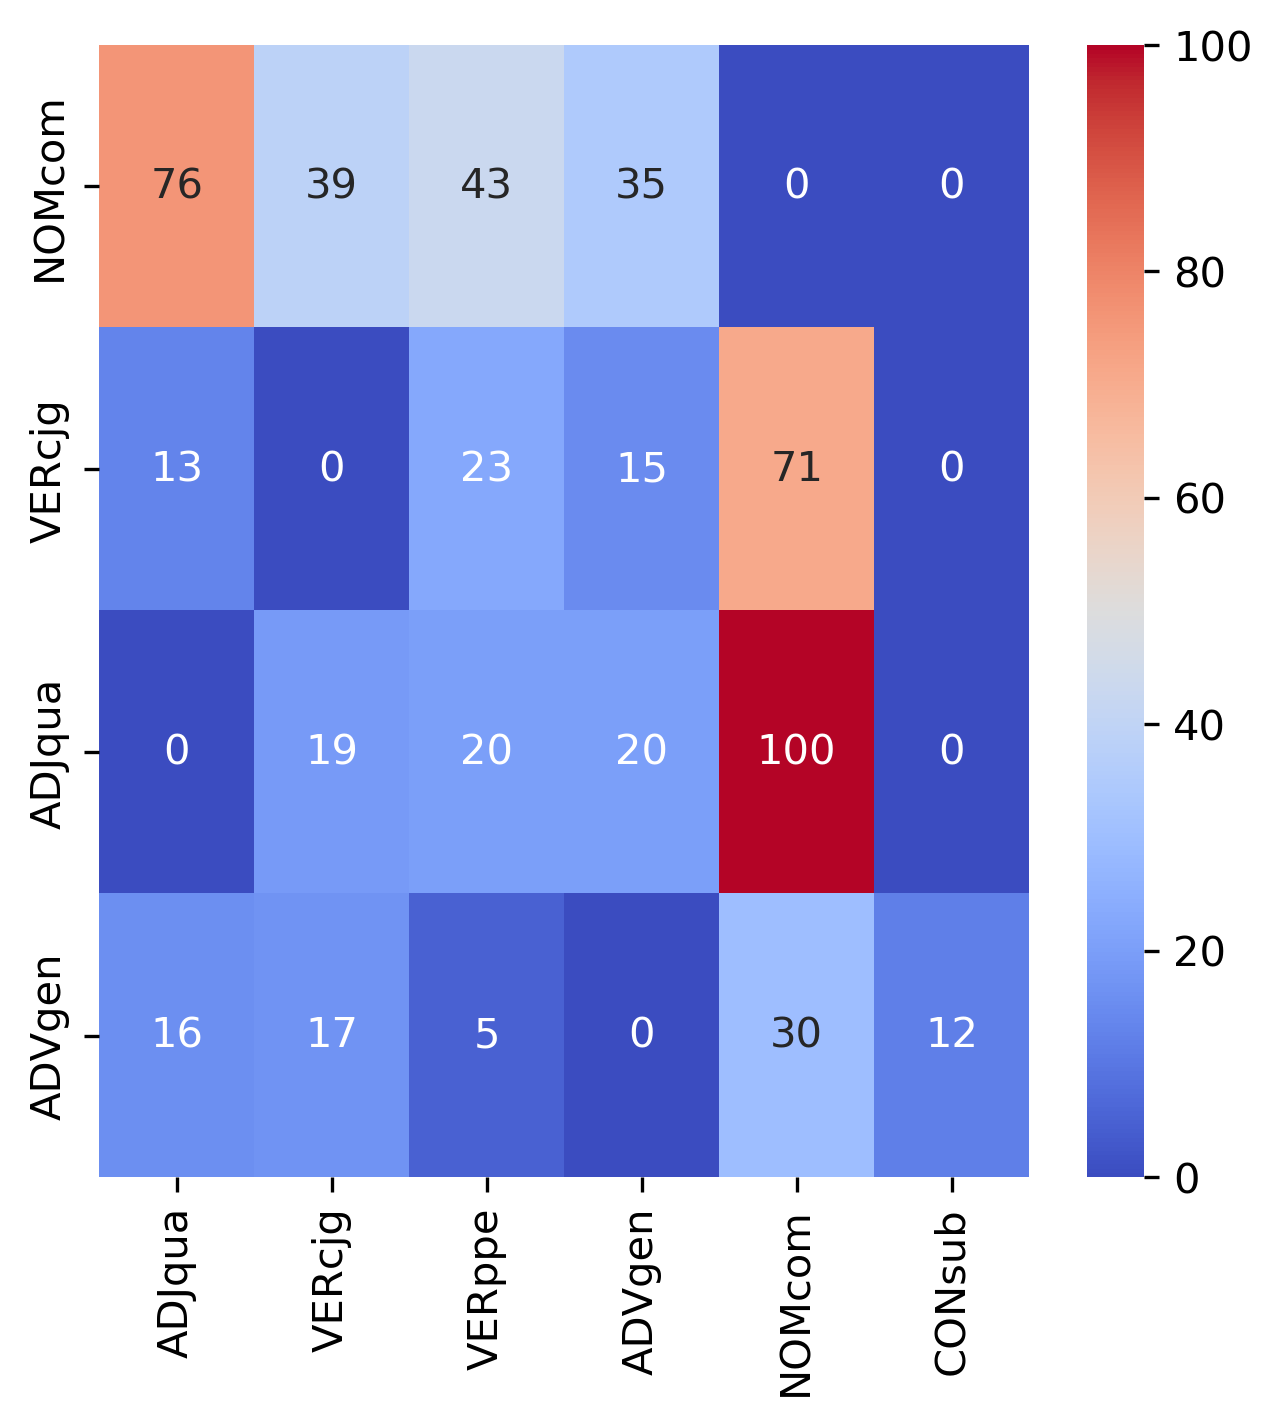

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax = sns.heatmap(confMatDf, annot=True, fmt=".0f", cmap = "coolwarm")

# Scores by text, scripta, genre

## Get metadata and annotate texts individually

In [136]:
metadata = pd.read_csv("metadataRevuSansSpace_Genres.tsv", sep="\t")
metadata = metadata[["deaf","dateManuscritType","genreType"]]
metadata

,deaf,dateManuscritType,genreType
0,OrsonP,2emxiiie,chgeste
1,RenN_H,2emxiiie,narrbref
2,Perclo_R,1emxiiie,roman
3,AdHaleRobS*,2emxiiie,theatre
4,RenBeaujBelW2,2emxiiie,narrbref
...,...,...,...
288,MarieFab_B,2emxiiie,narrbref
289,MarieFab_Y,1emxiiie,narrbref
290,ChastVergiS_K,mxive,narrbref
291,MarieLaisE2,2emxiiie,narrbref


In [242]:
ScoresWithMetad = defaultdict(list)

for sample in list(GOLD.keys()):
    title = sample.rpartition('_')[0]
    myMetads = metadata.loc[(metadata[["deaf"]] == title).values,]
    
    if len(myMetads) == 0:
        print("Error for sample: "+sample)
    
    else:
        ScoresWithMetad[sample] = {"Text": title, 
                                   "dateManuscritType": myMetads[["dateManuscritType"]].values[0][0],
                                   "lieuManuscritType": myMetads[["dateManuscritType"]].values[0][0],
                                  "genreType":myMetads[["genreType"]].values[0][0],
                                   "POS-acc":0.00,
                                   "lemma-acc":0.00
                                  }

ScoresWithMetad
pd.DataFrame(ScoresWithMetad, dtype=float).transpose()
#myMetads[["dateManuscritType"]].values[0]

,Text,dateManuscritType,lieuManuscritType,genreType,POS-acc,lemma-acc
ChastVergiS_A_69,ChastVergiS_A,2emxiiie,2emxiiie,narrbref,0.0,0.0
PsLorrA_672,PsLorrA,2emxive,2emxive,bible,0.0,0.0
PerNeslesTabJ_602,PerNeslesTabJ,2emxiiie,2emxiiie,nil,0.0,0.0
MerlinP_956,MerlinP,1emxive,1emxive,roman,0.0,0.0
MerlinP_1603,MerlinP,1emxive,1emxive,roman,0.0,0.0
...,...,...,...,...,...,...
YvainL;PercL_1311,YvainL;PercL,1emxiiie,1emxiiie,roman,0.0,0.0
YvainL;PercL_1877,YvainL;PercL,1emxiiie,1emxiiie,roman,0.0,0.0
CharroiSch_B2*_739,CharroiSch_B2*,1emxive,1emxive,narrbref,0.0,0.0
VillehF_658,VillehF,2emxive,2emxive,hist,0.0,0.0


In [164]:
# And now we need the scores
PLATINUM_byText = defaultdict(list)


for text in list(GOLD.keys()):
    PLATINUM_byText[text] = [
    sentence for sentence in convert_raw(GOLD[text], form_fn = lambda x: x.replace('§', ''))
]

PLATINUM_byText

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19925.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22052.07it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 6428.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14051.27it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 32171.08it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13771.17it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 5223.29it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20030.11it/s]
0it [00:00, ?it/s]


defaultdict(list,
            {'ChastVergiS_A_69': [[{'form': 'Longue',
                'lemma': 'lonc',
                'POS': 'ADJqua'},
               {'form': 'atente', 'lemma': 'atente', 'POS': 'NOMcom'},
               {'form': 'vous', 'lemma': 'vos', 'POS': 'PROper'},
               {'form': 'poroit', 'lemma': 'pöoir', 'POS': 'VERcjg'},
               {'form': 'nuire', 'lemma': 'nuire', 'POS': 'VERinf'},
               {'form': ',', 'lemma': ',', 'POS': 'PONfbl'},
               {'form': 'ce', 'lemma': 'ce1', 'POS': 'PROdem'},
               {'form': "m'", 'lemma': 'je', 'POS': 'PROper'},
               {'form': 'est', 'lemma': 'estre1', 'POS': 'VERcjg'},
               {'form': 'vis', 'lemma': 'vis2', 'POS': 'NOMcom'},
               {'form': ':', 'lemma': ':', 'POS': 'PONfbl'},
               {'form': 'si', 'lemma': 'si', 'POS': 'ADVgen'},
               {'form': 'lo', 'lemma': 'löer1', 'POS': 'VERcjg'},
               {'form': 'que', 'lemma': 'que4', 'POS': 'CONsub'},
       

In [166]:
TOKENS_byText = defaultdict(list)
for text in PLATINUM_byText:
    TOKENS_byText[text] = [[x["form"] for x in sentence]
                           for sentence in PLATINUM_byText[text]]
    
# Vérif romains
#[t for s in TOKENS for t in s if t[0] == '.']
# vérif tokens
TOKENS_byText["ChastVergiS_A_69"]

[['Longue',
  'atente',
  'vous',
  'poroit',
  'nuire',
  ',',
  'ce',
  "m'",
  'est',
  'vis',
  ':',
  'si',
  'lo',
  'que',
  'vous',
  'soiiés',
  'amis',
  'en',
  'un',
  'haut',
  'liu',
  ',',
  'se',
  'vous',
  'veés',
  'que',
  'vous',
  'i',
  'soiiés',
  'bien',
  'amés',
  '.'],
 ['»',
  'Cil',
  'respont',
  ':',
  '«',
  'Ma',
  'dame',
  ',',
  'par',
  'foi',
  ',',
  'je',
  'ne',
  'sai',
  'mie',
  'bien',
  'por',
  'quoi',
  'ce',
  'me',
  'dites',
  "n'",
  'à',
  'coi',
  'ce',
  'monte',
  ',',
  'mais',
  'je',
  'ne',
  'sui',
  'ne',
  'rois',
  'ne',
  'conte',
  'qui',
  'si',
  'hautement',
  'amer',
  'doie',
  ',',
  'ne',
  'je',
  'n’',
  'en',
  'sui',
  'mie',
  'à',
  '.II.',
  'doie',
  "d'",
  'amer',
  'dame',
  'si',
  'soveraine',
  ',',
  'se',
  'je',
  'bien',
  'i',
  'metoie',
  'paine',
  '.'],
 ['-',
  'Si',
  'estes',
  ',',
  '»',
  'fait',
  'ele',
  ',',
  '«',
  'se',
  'devient',
  ';',
  'mainte',
  'plus',
  'grans',
  'me

In [169]:
# Lemmatise
OUTPUT_byText = defaultdict(list)

DEVICE = "cpu"
BATCH_SIZE = 64

TEST_NEW = True

#tagger = Tagger(device="cuda", batch_size=100, lower=False, tokenize=False)
tagger = Tagger(device=DEVICE, batch_size=BATCH_SIZE, lower=False, tokenize=False)
if TEST_NEW:
    for task in TASKS:
        tagger.add_model(f"modeles/{task}.tar", task)
#else:
#    tagger.add_model("../../../latin-lasla-models/lasla-plus.tar", *TASKS)

for text in TOKENS_byText:
    for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS_byText[text]], tagger.batch_size)):
        tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
        OUTPUT_byText[text].extend([
            [
                (token, dict(zip(tasks, result)))
                for token, result in sentence
            ]
            for sentence in tagged
        ])



1it [00:00,  4.19it/s]
1it [00:00,  3.45it/s]
1it [00:00,  6.68it/s]
1it [00:00,  4.12it/s]
1it [00:00,  2.84it/s]
1it [00:00,  4.16it/s]
1it [00:00,  2.43it/s]
1it [00:00,  5.06it/s]
1it [00:00,  5.06it/s]
1it [00:00,  4.88it/s]
1it [00:00,  4.86it/s]
1it [00:00,  3.59it/s]
1it [00:00,  3.76it/s]
1it [00:00,  3.76it/s]
1it [00:00,  3.82it/s]
1it [00:00,  3.61it/s]
1it [00:00,  4.67it/s]
1it [00:00,  3.30it/s]
1it [00:00,  1.44it/s]
1it [00:00,  4.55it/s]
1it [00:00,  5.56it/s]
1it [00:00,  4.77it/s]
1it [00:00,  3.81it/s]
1it [00:00,  4.53it/s]
1it [00:00,  4.32it/s]
1it [00:00,  4.93it/s]
1it [00:00,  3.23it/s]
1it [00:00,  3.60it/s]
1it [00:00,  1.46it/s]
1it [00:00,  4.53it/s]
1it [00:00,  3.62it/s]
1it [00:00,  4.89it/s]
1it [00:00,  4.79it/s]
1it [00:00,  4.66it/s]
1it [00:00,  3.00it/s]
1it [00:00,  3.69it/s]
1it [00:00,  3.39it/s]
1it [00:00,  6.64it/s]
1it [00:00,  3.22it/s]
1it [00:00,  5.45it/s]
1it [00:00,  4.51it/s]
1it [00:00,  3.89it/s]
1it [00:00,  2.73it/s]
1it [00:00,

In [170]:
OUTPUT_byText["ChastVergiS_A_69"]

[[('Longue', {'POS': 'ADJqua', 'lemma': 'lonc'}),
  ('atente', {'POS': 'NOMcom', 'lemma': 'atente'}),
  ('vous', {'POS': 'PROper', 'lemma': 'vos'}),
  ('poroit', {'POS': 'VERcjg', 'lemma': 'pöoir'}),
  ('nuire', {'POS': 'VERinf', 'lemma': 'nuire'}),
  (',', {'POS': 'PONfbl', 'lemma': ','}),
  ('ce', {'POS': 'PROdem', 'lemma': 'ce1'}),
  ("m'", {'POS': 'PROper', 'lemma': 'je'}),
  ('est', {'POS': 'VERcjg', 'lemma': 'estre1'}),
  ('vis', {'POS': 'ADJqua', 'lemma': 'vif'}),
  (':', {'POS': 'PONfbl', 'lemma': ':'}),
  ('si', {'POS': 'ADVgen', 'lemma': 'si'}),
  ('lo', {'POS': 'PROper', 'lemma': 'löer1'}),
  ('que', {'POS': 'CONsub', 'lemma': 'que4'}),
  ('vous', {'POS': 'PROper', 'lemma': 'vos'}),
  ('soiiés', {'POS': 'VERcjg', 'lemma': 'estre1'}),
  ('amis', {'POS': 'NOMcom', 'lemma': 'ami'}),
  ('en', {'POS': 'PRE', 'lemma': 'en1'}),
  ('un', {'POS': 'DETndf', 'lemma': 'un'}),
  ('haut', {'POS': 'ADJqua', 'lemma': 'haut'}),
  ('liu', {'POS': 'NOMcom', 'lemma': 'lieu'}),
  (',', {'POS': '

In [243]:
ScoresWithMetad.keys()

for text in list(ScoresWithMetad.keys()):
    #print(text)
    _, Scores_all3, *_, Score_Knowns = compile_scores(OUTPUT_byText[text], PLATINUM_byText[text], 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                     known_lemmas=KNOWN_LEMMAS)
    
    
    RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT_byText[text], PLATINUM_byText[text], task_list=TASKS, 
        known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS)
    

    for task, (pred, truth) in RAW_SCORES.items():
        #(pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
        ScoresWithMetad[text][task+'-acc'] = "{0:.2f}".format(accuracy_score(truth, pred)*100)#,
            #"{0:.2f}".format(accuracy_score(pred_limited, truth_limited)*100)
        

dfFull = pd.DataFrame(ScoresWithMetad).transpose()    
dfFull
#dfFull[dfFull.index.duplicated()]

,Text,dateManuscritType,lieuManuscritType,genreType,POS-acc,lemma-acc
ChastVergiS_A_69,ChastVergiS_A,2emxiiie,2emxiiie,narrbref,96.58,95.73
PsLorrA_672,PsLorrA,2emxive,2emxive,bible,90.74,88.27
PerNeslesTabJ_602,PerNeslesTabJ,2emxiiie,2emxiiie,nil,83.67,79.59
MerlinP_956,MerlinP,1emxive,1emxive,roman,94.55,93.64
MerlinP_1603,MerlinP,1emxive,1emxive,roman,96.69,95.87
...,...,...,...,...,...,...
YvainL;PercL_1311,YvainL;PercL,1emxiiie,1emxiiie,roman,94.74,95.79
YvainL;PercL_1877,YvainL;PercL,1emxiiie,1emxiiie,roman,98.26,98.26
CharroiSch_B2*_739,CharroiSch_B2*,1emxive,1emxive,narrbref,93.50,82.93
VillehF_658,VillehF,2emxive,2emxive,hist,96.55,94.25


## Scripta vs genre heatmap

In [258]:
dfFull[0:2][:].pivot(index="genreType", columns="lieuManuscritType", values="lemma-acc")
#df = pd.pivot_table(dfFull, index="genreType", columns="lieuManuscritType", values="lemma-acc", aggfunc=median)
# on restreint aux classes d'effectif au moins 5, et on trace
# sns.heatmap(df.loc[(df.sum(axis=1) > 4), (df.sum(axis=0) > 4)], annot=True)


lieuManuscritType,2emxiiie,2emxive
genreType,,
bible,NaN,88.27
narrbref,95.73,NaN


## Lemma and POS per scripta

## Lemma and POS per genre

## Lemma and POS per date